# Backbone Torsion Cluster Visualization

Presentation-quality plots for the GMM-based backbone torsion clustering approach.

**Data source:** `../data/backbone_clusters.json` (pre-computed GMM parameters)  
**Raw data:** Re-collected for 4 representative edge types (cWW, tWW, tWH, cSS)

In [ ]:
# Cell 1: Imports & data loading
import json
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import mahalanobis
from pathlib import Path

# Resolve project root (one level up from notebooks/)
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))

# Import functions from the generation script
from generate_backbone_clusters import (
    load_unique_pdb_ids,
    get_excluded_pdb_ids,
    collect_backbone_data,
    angles_to_sincos,
    fit_gmm_with_bic,
    get_sugar_pucker,
    compute_mahalanobis_threshold,
    MAX_GMM_K,
)

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)
plt.rcParams.update({"figure.dpi": 120, "savefig.dpi": 150})

# Load pre-computed cluster parameters (new pooled schema)
with open(PROJECT_ROOT / "data" / "backbone_clusters.json") as f:
    clusters_json = json.load(f)

global_clusters_data = clusters_json["global_clusters"]
edge_types_data = clusters_json["edge_types"]
print(f"Loaded global clusters: {list(global_clusters_data.keys())}")
for label, gc in global_clusters_data.items():
    print(f"  {label}: k={gc['n_components']}, n={gc['n_points']:,}")
print(f"Loaded weight profiles for {len(edge_types_data)} edge types")

# Collect raw torsion data for representative edge types
# This takes a few minutes
pdb_ids = load_unique_pdb_ids()
exclude = get_excluded_pdb_ids()
print(f"\nCollecting raw data from {len(pdb_ids - exclude)} PDBs...")
raw_data, raw_counts = collect_backbone_data(pdb_ids, exclude)

# Keep only the 4 edge types we need for plots
REPRESENTATIVE_EDGES = ["cWW", "tWW", "tWH", "cSS"]
raw_subset = {k: raw_data[k] for k in REPRESENTATIVE_EDGES if k in raw_data}
print(f"\nRaw data collected for: {list(raw_subset.keys())}")
for k, v in raw_subset.items():
    print(f"  {k}: {len(v):,} residue observations")

In [ ]:
# Cell 2: Overview table — global k + per-edge-type weight profiles

# Global cluster summary
print("GLOBAL CLUSTERS (shared across all edge types)")
print("=" * 50)
for label, gc in global_clusters_data.items():
    print(f"  {label}: k={gc['n_components']}, n={gc['n_points']:,}")

print(f"\nPER-EDGE-TYPE WEIGHT PROFILES")
print(f"{'Edge Type':<10} {'abg_c3_endo':>22} {'abg_c2_endo':>22} {'dez':>22} {'chi':>12}")
print("-" * 92)

for lw in sorted(edge_types_data.keys()):
    et = edge_types_data[lw]
    cols = []
    for group in ["abg_c3_endo", "abg_c2_endo", "dez"]:
        if group in et:
            g = et[group]
            top_w = max(g["weights"])
            cols.append(f"n={g['n_points']:,} top={top_w:.2f}")
        else:
            cols.append("--")
    if "chi" in et:
        cols.append(f"{et['chi']['modality'][:3]} n={et['chi']['count']:,}")
    else:
        cols.append("--")
    print(f"{lw:<10} {cols[0]:>22} {cols[1]:>22} {cols[2]:>22} {cols[3]:>12}")

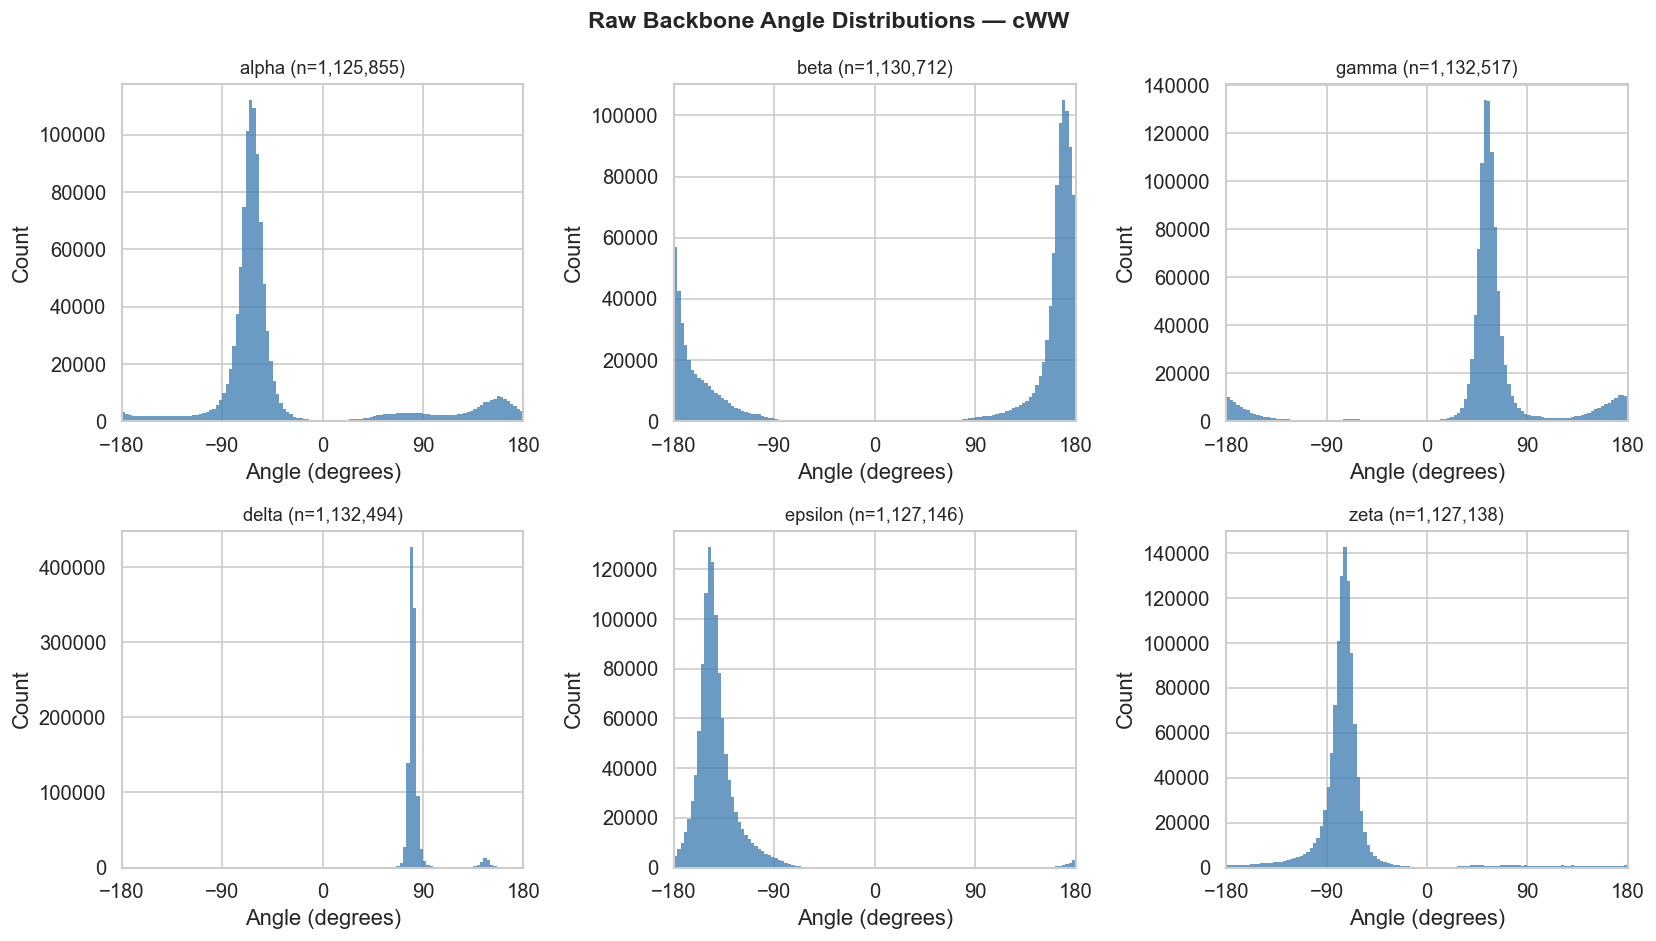

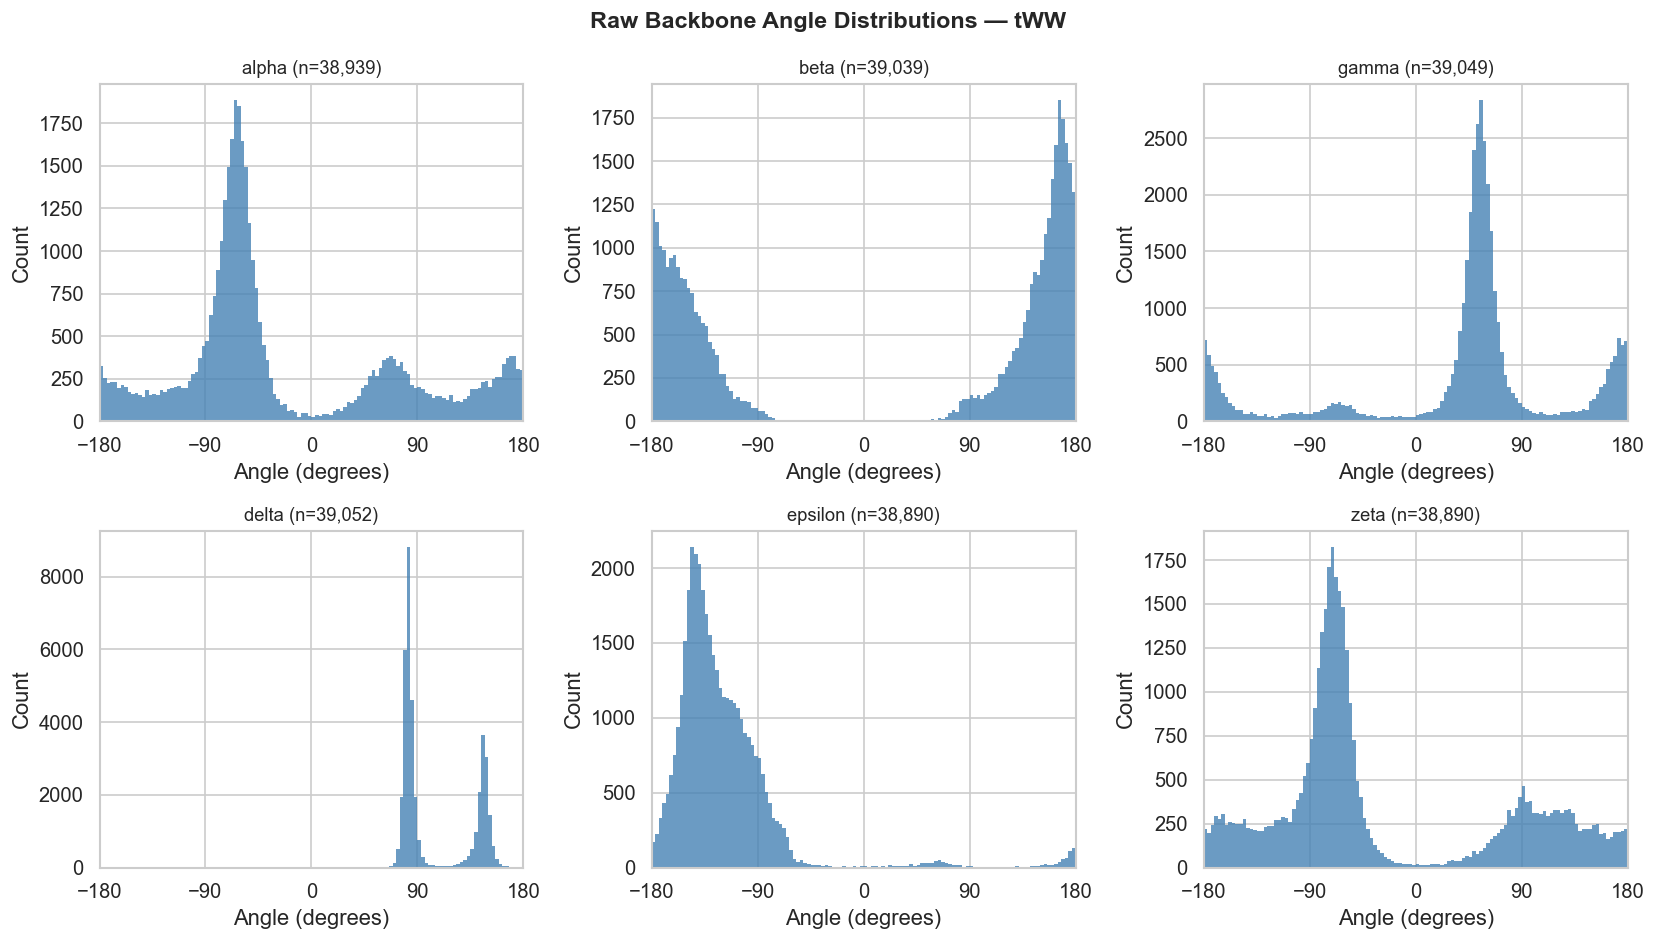

In [9]:
# Cell 3: Raw angle distributions (histograms)
# For cWW and tWW: 2x3 grid of histograms for alpha, beta, gamma, delta, epsilon, zeta

angle_names = ["alpha", "beta", "gamma", "delta", "epsilon", "zeta"]

for lw in ["cWW", "tWW"]:
    entries = raw_subset[lw]
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    fig.suptitle(f"Raw Backbone Angle Distributions — {lw}", fontsize=14, fontweight="bold")

    for idx, angle in enumerate(angle_names):
        ax = axes[idx // 3, idx % 3]
        vals = [e[angle] for e in entries if angle in e]
        if vals:
            ax.hist(vals, bins=120, range=(-180, 180), color="steelblue", alpha=0.8,
                    edgecolor="none")
        ax.set_title(f"{angle} (n={len(vals):,})", fontsize=11)
        ax.set_xlabel("Angle (degrees)")
        ax.set_ylabel("Count")
        ax.set_xlim(-180, 180)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(90))

    plt.tight_layout()
    plt.show()

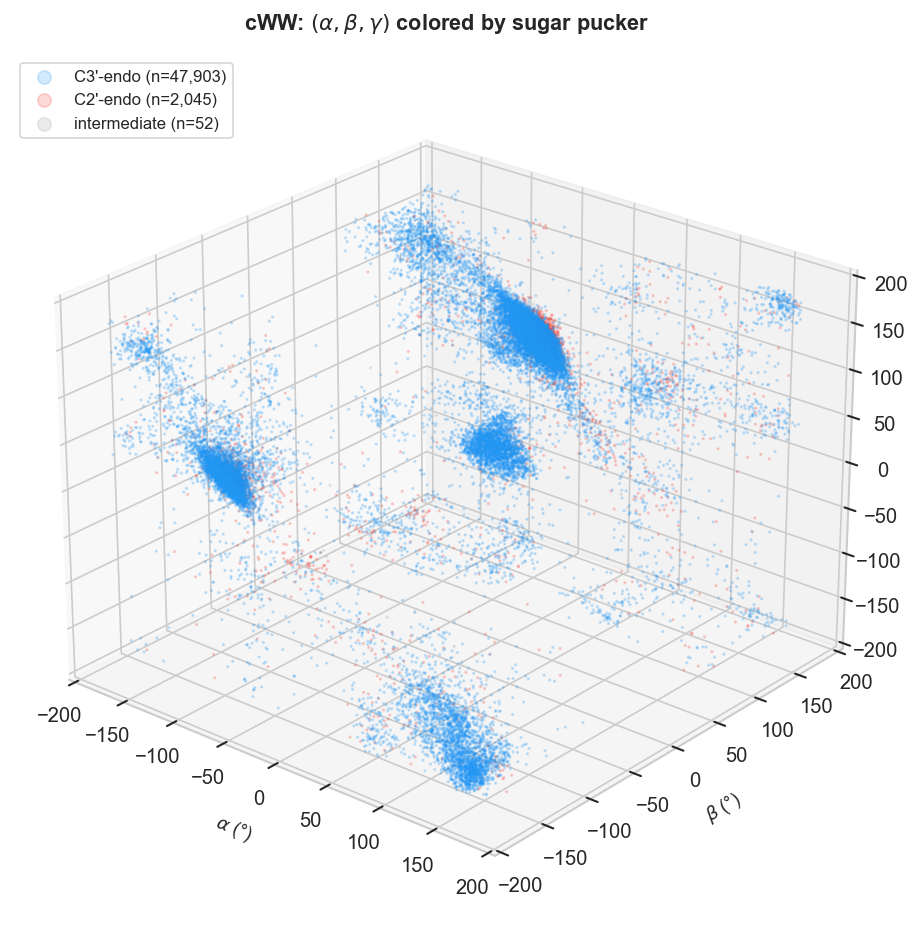

In [10]:
# Cell 4: Sugar pucker split visualization — 3D
# For cWW: 3D scatter of (alpha, beta, gamma) colored by sugar pucker

entries_cww = raw_subset["cWW"]

# Filter entries with alpha, beta, gamma, and delta
valid = [e for e in entries_cww if all(k in e for k in ("alpha", "beta", "gamma", "delta"))]

# Subsample for plotting performance
rng = np.random.RandomState(42)
if len(valid) > 50000:
    valid = [valid[i] for i in rng.choice(len(valid), 50000, replace=False)]

alpha = np.array([e["alpha"] for e in valid])
beta = np.array([e["beta"] for e in valid])
gamma = np.array([e["gamma"] for e in valid])
puckers = [get_sugar_pucker(e["delta"]) for e in valid]

pucker_colors = {"C3'-endo": "#2196F3", "C2'-endo": "#F44336", "intermediate": "#9E9E9E"}
pucker_order = ["C3'-endo", "C2'-endo", "intermediate"]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

for pucker in pucker_order:
    mask = np.array([p == pucker for p in puckers])
    n = mask.sum()
    if n > 0:
        ax.scatter(alpha[mask], beta[mask], gamma[mask], s=1, alpha=0.2,
                   color=pucker_colors[pucker], label=f"{pucker} (n={n:,})",
                   rasterized=True)

ax.set_xlabel(r"$\alpha$ (°)", fontsize=11, labelpad=8)
ax.set_ylabel(r"$\beta$ (°)", fontsize=11, labelpad=8)
ax.set_zlabel(r"$\gamma$ (°)", fontsize=11, labelpad=8)
ax.set_title(r"cWW: $(\alpha, \beta, \gamma)$ colored by sugar pucker",
             fontsize=13, fontweight="bold", pad=15)
ax.legend(markerscale=8, fontsize=10, loc="upper left")
ax.view_init(elev=25, azim=-50)
plt.tight_layout()
plt.show()

In [ ]:
# Cell 5: Global GMM clusters — (alpha, beta, gamma) C3'-endo
# Reconstruct GMM from global_clusters, color ALL pooled data by global cluster

# Reconstruct GMM from stored global params
gc_abg = global_clusters_data["abg_c3_endo"]
n_k = gc_abg["n_components"]

gmm_abg = GaussianMixture(n_components=n_k, covariance_type="full")
gmm_abg.means_ = np.array([c["mean"] for c in gc_abg["clusters"]])
gmm_abg.covariances_ = np.array([c["covariance"] for c in gc_abg["clusters"]])
gmm_abg.weights_ = np.ones(n_k) / n_k  # uniform (weights are edge-specific)
gmm_abg.precisions_cholesky_ = np.linalg.cholesky(
    np.linalg.inv(gmm_abg.covariances_)
)

# Collect ALL C3'-endo ABG data across edge types for display
all_c3_entries = []
for entries in raw_data.values():
    for e in entries:
        if all(k in e for k in ("alpha", "beta", "gamma", "delta")):
            if get_sugar_pucker(e["delta"]) == "C3'-endo":
                all_c3_entries.append(e)

angles_abg = np.array([[e["alpha"], e["beta"], e["gamma"]] for e in all_c3_entries])
X_abg = angles_to_sincos(angles_abg)
labels_abg = gmm_abg.predict(X_abg)
print(f"Global C3'-endo ABG: {len(all_c3_entries):,} points, {n_k} clusters")

# Subsample for plotting
rng = np.random.RandomState(42)
max_plot = 50000
if len(angles_abg) > max_plot:
    idx = rng.choice(len(angles_abg), max_plot, replace=False)
    ang_plot = angles_abg[idx]
    labels_plot = labels_abg[idx]
else:
    ang_plot = angles_abg
    labels_plot = labels_abg

cluster_cmap = plt.cm.tab20 if n_k > 10 else plt.cm.tab10

# --- Main 3D scatter ---
fig = plt.figure(figsize=(11, 9))
ax3d = fig.add_subplot(111, projection="3d")

for k in range(n_k):
    mask = labels_plot == k
    ax3d.scatter(ang_plot[mask, 0], ang_plot[mask, 1], ang_plot[mask, 2],
                 s=1, alpha=0.2, color=cluster_cmap(k), rasterized=True)

ax3d.set_xlabel(r"$\alpha$ (°)", fontsize=11, labelpad=8)
ax3d.set_ylabel(r"$\beta$ (°)", fontsize=11, labelpad=8)
ax3d.set_zlabel(r"$\gamma$ (°)", fontsize=11, labelpad=8)
ax3d.set_title(r"Global C3$'$-endo: Pooled GMM Clusters in $(\alpha,\beta,\gamma)$ space",
               fontsize=13, fontweight="bold", pad=15)
handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=cluster_cmap(k),
                       markersize=8, label=f"Cluster {k+1}") for k in range(n_k)]
ax3d.legend(handles=handles, fontsize=9, loc="upper left",
            ncol=2 if n_k > 8 else 1)
ax3d.view_init(elev=25, azim=-50)
plt.tight_layout()
plt.show()

# --- Two complementary 2D projections ---
fig, axes = plt.subplots(1, 2, figsize=(13, 5.5))
fig.suptitle(r"Global C3$'$-endo: Pooled GMM Cluster 2D Projections",
             fontsize=13, fontweight="bold")

proj_pairs = [(0, 2, r"$\alpha$", r"$\gamma$"),
              (0, 1, r"$\alpha$", r"$\beta$")]

for ax, (xi, yi, xl, yl) in zip(axes, proj_pairs):
    for k in range(n_k):
        mask = labels_plot == k
        ax.scatter(ang_plot[mask, xi], ang_plot[mask, yi], s=1, alpha=0.2,
                   color=cluster_cmap(k), rasterized=True)
    ax.set_xlabel(f"{xl} (°)", fontsize=11)
    ax.set_ylabel(f"{yl} (°)", fontsize=11)

fig.legend(handles=handles, loc="lower center", ncol=min(n_k, 8), fontsize=9,
           bbox_to_anchor=(0.5, -0.02))
plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()

In [ ]:
# Cell 6: Global GMM clusters — (delta, epsilon, zeta)
# Reconstruct GMM from global_clusters, color ALL pooled data by global cluster

# Reconstruct GMM from stored global params
gc_dez = global_clusters_data["dez"]
n_k_dez = gc_dez["n_components"]

gmm_dez = GaussianMixture(n_components=n_k_dez, covariance_type="full")
gmm_dez.means_ = np.array([c["mean"] for c in gc_dez["clusters"]])
gmm_dez.covariances_ = np.array([c["covariance"] for c in gc_dez["clusters"]])
gmm_dez.weights_ = np.ones(n_k_dez) / n_k_dez
gmm_dez.precisions_cholesky_ = np.linalg.cholesky(
    np.linalg.inv(gmm_dez.covariances_)
)

# Collect ALL DEZ data across edge types
all_dez_entries = []
for entries in raw_data.values():
    for e in entries:
        if all(k in e for k in ("delta", "epsilon", "zeta")):
            all_dez_entries.append(e)

angles_dez = np.array([[e["delta"], e["epsilon"], e["zeta"]] for e in all_dez_entries])
X_dez = angles_to_sincos(angles_dez)
labels_dez = gmm_dez.predict(X_dez)
print(f"Global DEZ: {len(all_dez_entries):,} points, {n_k_dez} clusters")

# Subsample
rng = np.random.RandomState(42)
max_plot = 50000
if len(angles_dez) > max_plot:
    idx = rng.choice(len(angles_dez), max_plot, replace=False)
    ang_plot_dez = angles_dez[idx]
    labels_plot_dez = labels_dez[idx]
else:
    ang_plot_dez = angles_dez
    labels_plot_dez = labels_dez

cluster_cmap = plt.cm.tab20 if n_k_dez > 10 else plt.cm.tab10

# --- Main 3D scatter ---
fig = plt.figure(figsize=(11, 9))
ax3d = fig.add_subplot(111, projection="3d")

for k in range(n_k_dez):
    mask = labels_plot_dez == k
    ax3d.scatter(ang_plot_dez[mask, 0], ang_plot_dez[mask, 1], ang_plot_dez[mask, 2],
                 s=1, alpha=0.2, color=cluster_cmap(k), rasterized=True)

ax3d.set_xlabel(r"$\delta$ (°)", fontsize=11, labelpad=8)
ax3d.set_ylabel(r"$\epsilon$ (°)", fontsize=11, labelpad=8)
ax3d.set_zlabel(r"$\zeta$ (°)", fontsize=11, labelpad=8)
ax3d.set_title(r"Global: Pooled GMM Clusters in $(\delta,\epsilon,\zeta)$ space",
               fontsize=13, fontweight="bold", pad=15)
handles_dez = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=cluster_cmap(k),
                           markersize=8, label=f"Cluster {k+1}") for k in range(n_k_dez)]
ax3d.legend(handles=handles_dez, fontsize=9, loc="upper left",
            ncol=2 if n_k_dez > 8 else 1)
ax3d.view_init(elev=25, azim=-50)
plt.tight_layout()
plt.show()

# --- Two complementary 2D projections ---
fig, axes = plt.subplots(1, 2, figsize=(13, 5.5))
fig.suptitle(r"Global: Pooled GMM Cluster 2D Projections $(\delta,\epsilon,\zeta)$",
             fontsize=13, fontweight="bold")

proj_pairs = [(0, 2, r"$\delta$", r"$\zeta$"),
              (0, 1, r"$\delta$", r"$\epsilon$")]

for ax, (xi, yi, xl, yl) in zip(axes, proj_pairs):
    for k in range(n_k_dez):
        mask = labels_plot_dez == k
        ax.scatter(ang_plot_dez[mask, xi], ang_plot_dez[mask, yi], s=1, alpha=0.2,
                   color=cluster_cmap(k), rasterized=True)
    ax.set_xlabel(f"{xl} (°)", fontsize=11)
    ax.set_ylabel(f"{yl} (°)", fontsize=11)

fig.legend(handles=handles_dez, loc="lower center", ncol=min(n_k_dez, 8), fontsize=9,
           bbox_to_anchor=(0.5, -0.02))
plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()

In [ ]:
# Cell 7: Mahalanobis distance distributions
# For global abg_c3_endo: histogram of Mahalanobis distances per cluster

# Re-use the reconstructed GMM and pooled data from cell 5
thresholds_abg = [c["mahalanobis_threshold"] for c in gc_abg["clusters"]]

n_cols = min(n_k, 5)
n_rows = (n_k + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
fig.suptitle(r"Global C3$'$-endo ABG: Mahalanobis Distance per Cluster",
             fontsize=13, fontweight="bold")

for k in range(n_k):
    ax = axes[k // n_cols, k % n_cols]
    mask = labels_abg == k
    pts = X_abg[mask]
    mean_k = gmm_abg.means_[k]
    cov_k = gmm_abg.covariances_[k]
    try:
        cov_inv = np.linalg.inv(cov_k)
    except np.linalg.LinAlgError:
        cov_inv = np.linalg.pinv(cov_k)

    # Subsample for speed if cluster is large
    if len(pts) > 20000:
        rng_mah = np.random.RandomState(42)
        sub_idx = rng_mah.choice(len(pts), 20000, replace=False)
        pts_sub = pts[sub_idx]
    else:
        pts_sub = pts
    dists = np.array([mahalanobis(p, mean_k, cov_inv) for p in pts_sub])
    thr = thresholds_abg[k]
    frac_outside = np.mean(dists > thr) * 100

    ax.hist(dists, bins=80, color="steelblue", alpha=0.8, edgecolor="none")
    ax.axvline(thr, color="red", linestyle="--", linewidth=2,
               label=f"97.5th pctl = {thr:.2f}")
    ax.set_title(f"Cluster {k+1} (n={mask.sum():,})")
    ax.set_xlabel("Mahalanobis distance")
    ax.set_ylabel("Count")
    ax.legend(fontsize=8)
    ax.annotate(f"{frac_outside:.1f}% outside", xy=(0.95, 0.92),
                xycoords="axes fraction", ha="right", fontsize=9, color="red")

# Hide unused subplots
for k in range(n_k, n_rows * n_cols):
    axes[k // n_cols, k % n_cols].set_visible(False)

plt.tight_layout()
plt.show()

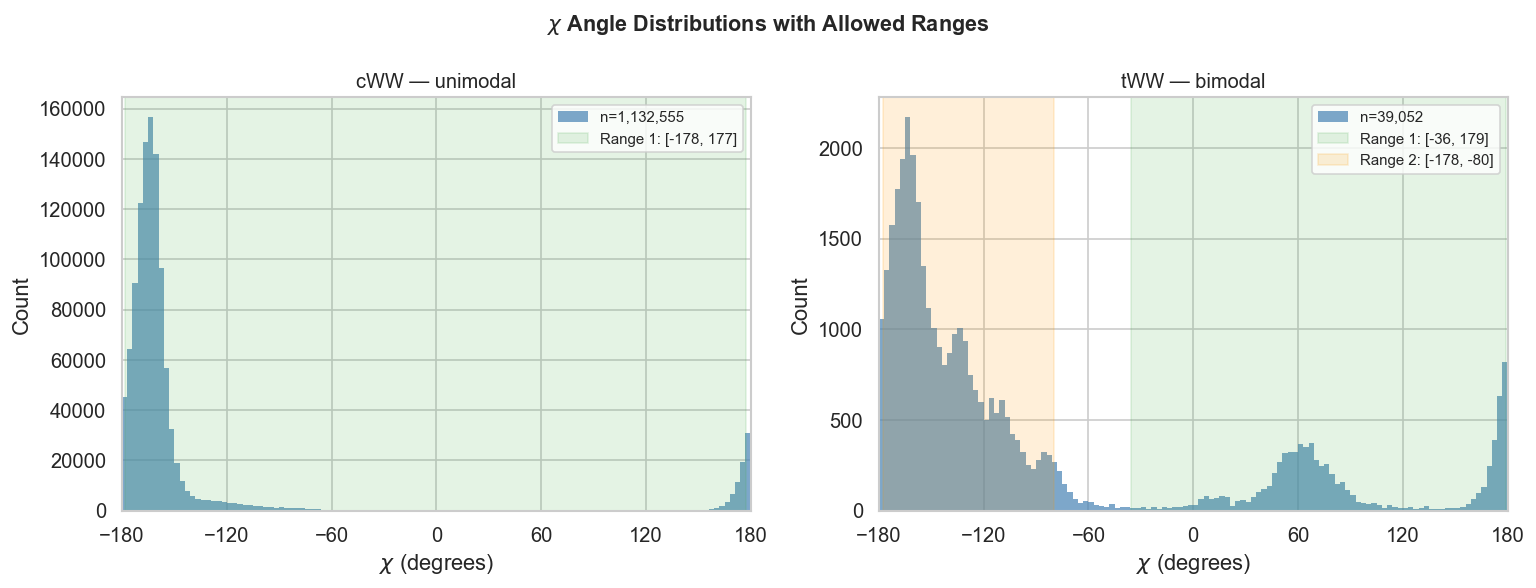

In [14]:
# Cell 8: Chi angle analysis
# For cWW (unimodal) and tWW (bimodal): chi histograms with shaded allowed ranges

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle(r"$\chi$ Angle Distributions with Allowed Ranges", fontsize=13, fontweight="bold")

for idx, lw in enumerate(["cWW", "tWW"]):
    ax = axes[idx]
    entries = raw_subset[lw]
    chi_vals = np.array([e["chi"] for e in entries if "chi" in e])

    ax.hist(chi_vals, bins=120, range=(-180, 180), color="steelblue", alpha=0.7,
            edgecolor="none", label=f"n={len(chi_vals):,}")

    # Overlay allowed ranges from clusters_json
    if lw in edge_types_data and "chi" in edge_types_data[lw]:
        chi_info = edge_types_data[lw]["chi"]
        colors_range = ["#4CAF50", "#FF9800"]
        for r_idx, rng_val in enumerate(chi_info["ranges"]):
            ax.axvspan(rng_val[0], rng_val[1], alpha=0.15, color=colors_range[r_idx % 2],
                       label=f"Range {r_idx+1}: [{rng_val[0]:.0f}, {rng_val[1]:.0f}]")
        modality = chi_info["modality"]
    else:
        modality = "N/A"

    ax.set_title(f"{lw} — {modality}", fontsize=12)
    ax.set_xlabel(r"$\chi$ (degrees)")
    ax.set_ylabel("Count")
    ax.set_xlim(-180, 180)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Cell 9: BIC model selection on POOLED data
# Fit on full pooled ABG C3'-endo and pooled DEZ datasets up to k=MAX_GMM_K

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("BIC Model Selection — Pooled Data", fontsize=13, fontweight="bold")

datasets = [
    (r"$(\alpha,\beta,\gamma)$ C3$'$-endo (pooled)", X_abg),
    (r"$(\delta,\epsilon,\zeta)$ (pooled)", X_dez),
]

for ax, (title, X) in zip(axes, datasets):
    # Subsample for BIC fitting speed (100k points is plenty for BIC)
    if len(X) > 100000:
        rng_bic = np.random.RandomState(42)
        X_bic = X[rng_bic.choice(len(X), 100000, replace=False)]
    else:
        X_bic = X
    bics = []
    ks = list(range(1, MAX_GMM_K + 1))
    for k in ks:
        gmm = GaussianMixture(n_components=k, covariance_type="full",
                              random_state=42, max_iter=200, n_init=3)
        gmm.fit(X_bic)
        bics.append(gmm.bic(X_bic))

    best_k = ks[np.argmin(bics)]

    ax.plot(ks, bics, "o-", color="steelblue", linewidth=2, markersize=8)
    ax.axvline(best_k, color="red", linestyle="--", alpha=0.7,
               label=f"Selected k={best_k}")
    ax.scatter([best_k], [bics[best_k - 1]], s=150, color="red", zorder=5,
               edgecolors="darkred", linewidths=1.5)
    ax.set_xlabel("Number of components (k)")
    ax.set_ylabel("BIC")
    ax.set_title(title, fontsize=12)
    ax.set_xticks(ks)
    ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Cell 10: Cross-edge-type comparison — weight profile heatmaps
# Shows which global conformations each edge type prefers

edge_list = sorted([k for k in edge_types_data.keys() if k != "_OTHER"])
edge_list.append("_OTHER")

for group_label, group_title in [
    ("abg_c3_endo", r"$(\alpha,\beta,\gamma)$ C3$'$-endo"),
    ("abg_c2_endo", r"$(\alpha,\beta,\gamma)$ C2$'$-endo"),
    ("dez", r"$(\delta,\epsilon,\zeta)$"),
]:
    if group_label not in global_clusters_data:
        continue
    n_clusters = global_clusters_data[group_label]["n_components"]

    # Build weight matrix: edge_types x clusters
    valid_edges = []
    weight_matrix = []
    for lw in edge_list:
        if lw in edge_types_data and group_label in edge_types_data[lw]:
            valid_edges.append(lw)
            weight_matrix.append(edge_types_data[lw][group_label]["weights"])

    if not weight_matrix:
        continue

    weight_matrix = np.array(weight_matrix)

    fig, ax = plt.subplots(figsize=(max(8, n_clusters * 0.8 + 2), len(valid_edges) * 0.4 + 2))
    im = ax.imshow(weight_matrix, aspect="auto", cmap="YlOrRd", vmin=0, vmax=1)

    ax.set_xticks(range(n_clusters))
    ax.set_xticklabels([f"C{k+1}" for k in range(n_clusters)], fontsize=9)
    ax.set_yticks(range(len(valid_edges)))
    ax.set_yticklabels(valid_edges, fontsize=10)
    ax.set_xlabel("Global Cluster", fontsize=11)
    ax.set_title(f"Weight Profiles — {group_title}", fontsize=13, fontweight="bold")

    # Annotate cells with weight values
    for i in range(len(valid_edges)):
        for j in range(n_clusters):
            w = weight_matrix[i, j]
            if w >= 0.01:
                color = "white" if w > 0.5 else "black"
                ax.text(j, i, f"{w:.2f}", ha="center", va="center",
                        fontsize=7, color=color)

    plt.colorbar(im, ax=ax, label="Weight (fraction of points)", shrink=0.8)
    plt.tight_layout()
    plt.show()

In [ ]:
# Cell 11: Pooled cluster summary
# With pooled clustering, clusters are unique by construction — no deduplication needed

print("POOLED CLUSTER SUMMARY")
print("=" * 60)
print("Clusters are shared across all edge types (unique by construction).\n")

for label, gc in global_clusters_data.items():
    n_k = gc["n_components"]
    n_pts = gc["n_points"]
    print(f"{label}:")
    print(f"  {n_k} global clusters fitted on {n_pts:,} pooled data points")

    # Show cluster sizes (from global threshold data — approximated via weight sums)
    thresholds = [c["mahalanobis_threshold"] for c in gc["clusters"]]
    for i, cl in enumerate(gc["clusters"]):
        print(f"    Cluster {i+1}: Mahalanobis threshold = {cl['mahalanobis_threshold']:.2f}")
    print()

# Weight distribution summary across edge types
print("WEIGHT DISTRIBUTION ACROSS EDGE TYPES")
print("=" * 60)
for group_label in ("abg_c3_endo", "abg_c2_endo", "dez"):
    if group_label not in global_clusters_data:
        continue
    n_k = global_clusters_data[group_label]["n_components"]
    print(f"\n{group_label} ({n_k} clusters):")

    # For each edge type, find the dominant cluster
    for lw in sorted(edge_types_data.keys()):
        et = edge_types_data[lw]
        if group_label not in et:
            continue
        weights = et[group_label]["weights"]
        dominant = np.argmax(weights)
        w_sum = sum(weights)
        print(f"  {lw:>8s}: dominant=C{dominant+1} ({weights[dominant]:.2f}), "
              f"weight_sum={w_sum:.4f}")